# Exploratory Data Analysis Team 17

Our goal is to build a predictive model that inputs a variety of features, both geographical and those that can quantify the extent of environmental injustice. Our model will predict which areas will be financially hardest hit by Hurricane Katrina.
***

## Handling Imports

In [106]:
!pip install geopandas

In [8]:
import base64
import datetime
import json
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona

In [107]:
!pip install --upgrade pip

***

## National Flood Hazard Layer Data

The National Flood Hazard Layer (NFHL) is a geospatial database that contains current effective flood hazard data. FEMA provides the flood hazard data to support the National Flood Insurance Program.

Variables that are of interest to us are the Flood Zone (FLD_ZONE) and Zone Subtype (ZONE_SUBTY) attributes.

### Flood Zone
This is a flood zone designation. These zones are used by FEMA to designate the SFHAs and for insurance rating purposes. 

**A** = 1-percent-annual-chance (base flood) floodplains, no Base Flood Elevations (BFEs)

**AE** = Zone that corresponds to the 1% annual chance floodplains with Base Flood Elevations

**AH** = Areas of 1-percent-annual-chance shallow flooding with a constant water-surface elevation where average depths are between 1 and 3 feet. 

**AO** = Zone AO are areas of sheet-flow shallow flooding where the potential runup is less than 3.0 feet above an overtopped barrier crest (R&lt;3.0 feet). The sheet flow in these areas will either flow into another flooding source (AE zone), result in ponding (AH zone) or deteriorate because of ground friction and energy losses and merge into the X zone. AO areas are designated with 1-, 2-, or 3-foot depths of flooding.

**AREA NOT INCLUDED** = Unknown

**D** = The Zone D designation is used for areas where there are possible but undetermined flood hazards. 

**OPEN WATER** = Unknown

**V** = Zone that corresponds to the 1% annual chance coastal floodplains that have additional hazards associated with storm waves. 

**VE** = Zone VE are coastal high hazard areas where wave action and/or high-velocity water can cause structural damage during the base flood. 

**X** = Zone X is classified as Shaded or Unshaded. Shaded Zone X: Areas of 0.2% annual chance flood hazards and areas of 1% annual chance flood hazards with average depths of less than 1 foot or with drainage areas less than 1 square mile. Unshaded Zone X: Areas of minimal flood hazard.

### Zone Subtype
**0.2 PCT ANNUAL CHANCE FLOOD HAZARD** = Shaded Zone X: Areas of 0.2% annual chance flood hazards.

**0.2 PCT ANNUAL CHANCE FLOOD HAZARD CONTAINED IN CHANNEL** = Shaded Zone X: Areas of 0.2% annual chance flood hazards.

**1 PCT DEPTH LESS THAN 1 FOOT** = Shaded Zone X: 1% annual chance flood hazards with average depths of less than 1 foot. This zone is classified as being within the 500 year floodplain and not the 100 year floodplain because of the following: Flood zones AH and AO reference a base flood depth between 1 and 3 feet. 

**AREA OF MINIMAL FLOOD HAZARD** = Unshaded Zone X: Areas of minimal flood hazard.

**AREA WITH REDUCED FLOOD RISK DUE TO LEVEE** = Area with Reduced Flood Risk due to Levee: Areas where an accredited levee, dike, or other flood control structure has reduced the flood risk from the 1% annual chance flood.

**FLOODWAY** = Unknown

**RIVERINE FLOODWAY SHOWN IN COASTAL ZONE** = Unknown

For more information: https://www.fla-etat.org/est/metadata/dfirm_sfha_sv.htm


In [108]:
# Map of the NFHL


# nfhl_df = gpd.read_file('./NFHL_FLD_HAZ_AR.shp')

In order to categorize the NFHL risk assessments by tract, the NFHL flood area layer merged with the TIGER tract GDB.

For more information on the TIGER database: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-geodatabase-file.html

In [112]:
# Viewing the cleaned dataset

nfhl_by_tract = pd.read_pickle('./nfhl_tiger.pkl')
nfhl_by_tract.head()

,FLD_ZONE,ZONE_SUBTY,SFHA_TF,Tract
0,X,AREA OF MINIMAL FLOOD HAZARD,F,9601
1,AE,NaN,T,9601
2,A,NaN,T,9601
3,AE,FLOODWAY,T,9601
4,X,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,F,9601


### Risk Level

**HIGH RISK - COASTAL AREAS** = In communities that participate in the NFIP, mandatory flood insurance purchase requirements apply to all of these zones: V, VE, V1 - 30.

**HIGH RISK AREAS** = In communities that participate in the NFIP, mandatory flood insurance purchase requirements apply to all of these zones: A, AE, A1-A30, AH, AO, AR, A99.

**MODERATE RISK AREAS** = In communities that participate in the NFIP, flood insurance is available to all property owners and renters in these zones: 0.2 PCT ANNUAL CHANCE FLOOD HAZARD

**MODERATE TO LOW RISK AREAS** = In communities that participate in the NFIP, flood insurance is available to all property owners and renters in these zones: B, C, and X. Insurance purchase is not required in these zones.

**OPEN WATER** = Body of open water that has no defined flood hazard.

**UNDETERMINED** = Areas with possible but undetermined flood hazards. No flood hazard analysis has been conducted. Flood insurance rates are commensurate with the uncertainty of the flood risk. Zone: D.

In [113]:
risk_level = {
    "high_coastal" : ["V", "VE", "V1 - 30"],
    "high" : ["A", "AE", "A1-A30", "AH", "AO", "AR", "A99"],
    "moderate_to_low" : ["B", "C", "X"],
    "undetermined" : ["D"]  
}

In [114]:
def risk_category(zone):
    for level in risk_level:
        if zone in risk_level[level]:
            return level

    return None

In [115]:
nfhl_by_tract["RISK"] = nfhl_by_tract["FLD_ZONE"].apply(risk_category)
nfhl_by_tract.loc[nfhl_by_tract["ZONE_SUBTY"] == "0.2 PCT ANNUAL CHANCE FLOOD HAZARD", "RISK"] = "moderate"

nfhl_by_tract

,FLD_ZONE,ZONE_SUBTY,SFHA_TF,Tract,RISK
0,X,AREA OF MINIMAL FLOOD HAZARD,F,9601,moderate_to_low
1,AE,NaN,T,9601,high
2,A,NaN,T,9601,high
3,AE,FLOODWAY,T,9601,high
4,X,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,F,9601,moderate
5,A,NaN,T,9602,high
6,X,AREA OF MINIMAL FLOOD HAZARD,F,9602,moderate_to_low
7,AE,NaN,T,9602,high
8,X,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,F,9602,moderate
9,AE,FLOODWAY,T,9602,high


In [116]:
# Determine which tracts are high risk

high_risk_tracts = nfhl_by_tract.loc[nfhl_by_tract['RISK'] == "high"]
num_high_risk =len(high_risk_tracts["Tract"].unique())
num_high_risk

559

In [117]:
nfhl_by_tract = nfhl_by_tract
risk_levels = nfhl_by_tract.groupby("RISK").size()

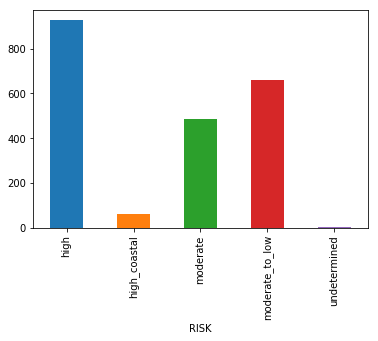

In [118]:
# Tracts containing differing risk levels
risk_levels.plot.bar()